In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ImportanceImputer import ImportanceImputer
import seaborn as sns
import numpy as np
import pickle

sns.set(
    { "figure.figsize": (17, 7) },
    style='ticks',
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=1.2
)
%config InlineBackend.figure_format = 'retina'

In [5]:
# Load the dataset
auto = pd.read_csv('ready_to_impute.csv')

<Axes: xlabel='year_of_registration'>

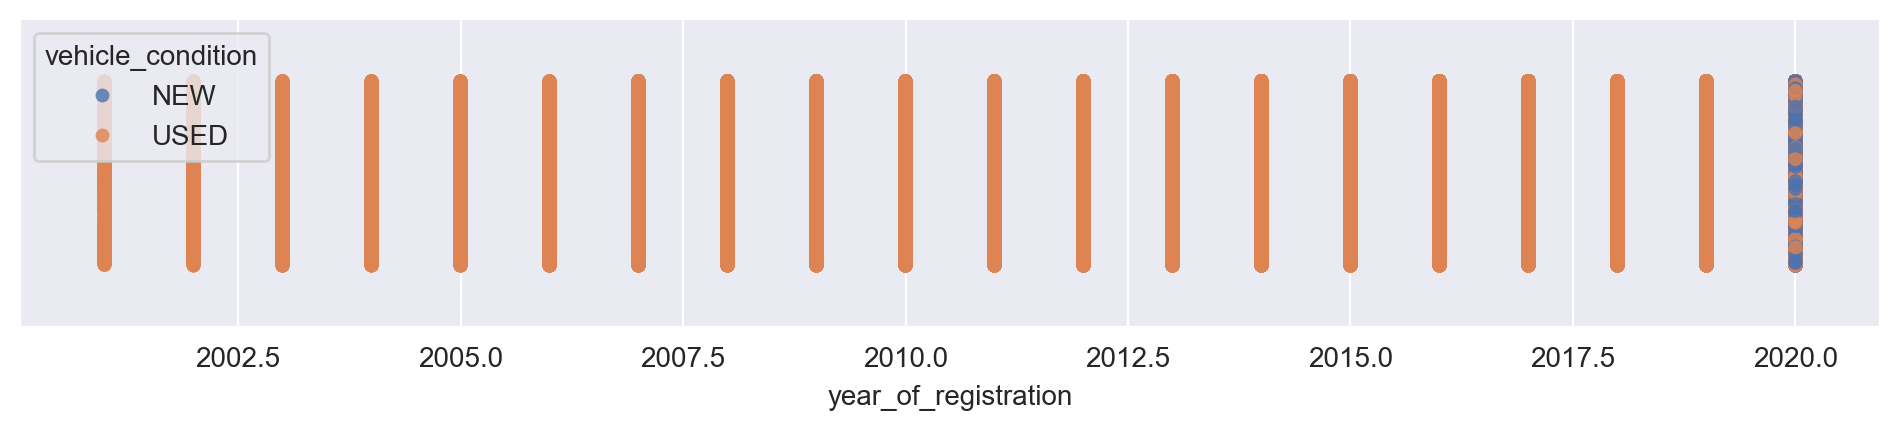

In [20]:
sns.set({ "figure.figsize": (12, 2) })
sns.stripplot(auto.loc[auto["year_of_registration"] > 2000], x="year_of_registration", jitter=0.3, hue="vehicle_condition", alpha=0.8)


In [189]:
auto.dropna(inplace=True)
auto = auto.reset_index(drop=True)

In [190]:
null_counts = pd.DataFrame({
    'column': auto.columns,
    'null_count': [auto[col].isnull().sum() for col in auto.columns]
})
null_counts.sort_values(by="null_count", ascending=False)

,column,null_count
0,mileage,0
1,standard_colour,0
2,standard_make,0
3,standard_model,0
4,vehicle_condition,0
5,year_of_registration,0
6,price,0
7,body_type,0
8,crossover_car_and_van,0
9,fuel_type,0


In [191]:
# Combine rare colours into larger groups

auto["standard_colour"].replace({
    "Navy": "Blue", 
    "Magenta": "Purple",
    "Burgundy": "Maroon",
    "Indigo": "Purple"
    }, inplace=True)

In [192]:
sample_size = 3000

In [193]:
sample = auto.sample(sample_size, random_state=42)

In [194]:
colour = sample[["standard_colour"]]
colour

,standard_colour
326904,Blue
216032,Black
219537,Black
364203,Red
269353,White
...,...
211429,Black
160099,Black
376654,Blue
303733,White


In [195]:
auto.loc[sample.index, "standard_colour"] = np.nan
auto.loc[sample.index]

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,year_listed,month_listed,day_listed
326904,0.0,NaN,Peugeot,2008,NEW,2020.0,24705.0,SUV,False,Petrol,2020,9,11
216032,7637.0,NaN,Toyota,Auris,USED,2017.0,14995.0,Hatchback,False,Petrol Hybrid,2020,10,12
219537,10.0,NaN,Audi,Q2,NEW,2020.0,31465.0,SUV,False,Petrol,2020,10,16
364203,40031.0,NaN,Vauxhall,Astra,USED,2017.0,7735.0,Hatchback,False,Diesel,2020,10,8
269353,11470.0,NaN,Nissan,Qashqai,USED,2018.0,18999.0,SUV,False,Diesel,2020,2,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211429,5910.0,NaN,Vauxhall,Corsa,USED,2016.0,10489.0,Hatchback,False,Petrol,2020,10,20
160099,648.0,NaN,Lexus,CT 200h,USED,2020.0,23991.0,Hatchback,False,Petrol Hybrid,2020,10,9
376654,162500.0,NaN,Land Rover,Discovery 4,USED,2011.0,9949.0,SUV,False,Diesel,2020,10,19
303733,17699.0,NaN,Volkswagen,Golf,USED,2019.0,16000.0,Hatchback,False,Petrol,2020,10,17


In [196]:
imputer = ImportanceImputer(similar_threshold=3, bin_numeric=False)

result = imputer.fit_transform(auto, "standard_colour")

auto.loc[result.index, "standard_colour"] = result["standard_colour"]

Matching features in order: ['standard_model', 'standard_make', 'vehicle_condition', 'fuel_type', 'body_type']
Imputing 3000 entries.


In [197]:
auto.loc[sample.index, "standard_colour"] = result["standard_colour"]

In [198]:
auto.loc[sample.index, "correct_colour"] = colour["standard_colour"]
auto.loc[sample.index, "standard_colour"].value_counts()

standard_colour
Black          1337
White           508
Grey            404
Blue            267
Silver          246
Red             215
Multicolour      20
Green             2
Bronze            1
Name: count, dtype: int64

In [199]:
print(f"Guessing mode has accuracy of {(auto["standard_colour"].mode()[0] == colour["standard_colour"]).value_counts()[1]/sample_size}")

Guessing mode has accuracy of 0.22366666666666668


In [200]:
print(f"ImportanceImputer has accuracy of {(auto.loc[sample.index]["standard_colour"] == colour["standard_colour"]).value_counts()[1]/sample_size}")

ImportanceImputer has accuracy of 0.2776666666666667


# Transforming Data

In [201]:
auto_transformed = pd.read_csv('transformed_auto2.csv')

In [202]:
from reverse_transform import reverse_encoding

auto_transformed = reverse_encoding(auto_transformed, column="standard_colour")

In [203]:
from sklearn.preprocessing import RobustScaler

cols_to_scale = ["make_model"]

# Scale data for KNN imputing
scaler = RobustScaler()
scaled_data = scaler.fit_transform(auto_transformed[cols_to_scale])
auto_transformed[cols_to_scale] = pd.DataFrame(scaled_data, columns=cols_to_scale)

In [204]:
sample = auto_transformed.sample(sample_size)

In [205]:
colour = sample[["standard_colour"]]

In [206]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
auto_transformed["standard_colour"] = label_encoder.fit_transform(auto_transformed["standard_colour"])

In [207]:
auto_transformed.loc[sample.index, "standard_colour"] = np.nan

In [208]:
from sklearn.impute import KNNImputer

# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=1)
knn_imputed_data = knn_imputer.fit_transform(auto_transformed)
knn_imputed_data = pd.DataFrame(knn_imputed_data, columns=auto_transformed.columns)
auto_transformed = knn_imputed_data

In [209]:
auto_transformed["standard_colour"] = auto_transformed["standard_colour"].map(lambda col: int(col))

In [210]:
auto_transformed["standard_colour"] = label_encoder.inverse_transform(auto_transformed["standard_colour"])

In [211]:
print(f"KNN Imputer has accuracy of {(auto_transformed.loc[sample.index]["standard_colour"] == colour["standard_colour"]).value_counts()[1]/sample_size}")

KNN Imputer has accuracy of 0.219
